# Spark Cognition: Challenge

<div style="text-align:justify">
You are working for SparkCognition as a Data Scientist. SparkCognition has been commissioned by an insurance company to develop a tool to optimize their marketing efforts. They have given us a data set as a result of an email marketing campaign. The data set includes customer information, described below, as a well as whether the customer responded to the marketing campaign or not.
</div>

## Load Packages

<div style="text-align:justify">
Here we will load the packages that will be used during the exploratory analysis and modeling. It is worth mentioning that we will use a <code>RandomOverSampler</code> class to generate random records from the minority class and we will compare the results of two algorithms: <code>RandomForestClassifier</code> and <code>MLPClassifier</code>. In both algorithms we will use cross-validation, through the <code>KFold</code> class.
</div>

In [1]:
import warnings, seaborn, pandas, numpy

from matplotlib import pyplot

from imblearn.over_sampling import RandomOverSampler

from scipy.stats import skew

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

%matplotlib inline

## Notebook Configuration

<div style="text-align:justify">
Next, we will set a default value for the <code>figure.figsize</code> attribute of the <code>matplotlib.pyplot</code> class. This will ensure that all images displayed on the notebook will be the same size.
</div>

In [2]:
pyplot.rcParams['figure.figsize'] = (15, 7)
warnings.filterwarnings('ignore')

## Fetch Train Dataset

<div style="text-align:justify">
After fetch the data we add a filter to remove outliers (<code>custAge> = 70</code>). More details in Block 10, below.
</div>

In [3]:
df = pandas.read_csv('marketing_training.csv')
df = df[(df['custAge'] < 70) | (df['custAge'].isna())] # drop outliers
df.head(5)

,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded
0,55.0,admin.,single,university.degree,unknown,no,no,cellular,nov,mon,...,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,999.0,0,no
1,NaN,blue-collar,married,NaN,no,no,no,cellular,jul,mon,...,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999.0,0,no
2,42.0,technician,married,high.school,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,999.0,0,no
3,55.0,management,divorced,NaN,unknown,yes,yes,cellular,jul,wed,...,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,999.0,0,no
4,NaN,admin.,divorced,university.degree,no,yes,no,cellular,may,tue,...,1,failure,-1.8,92.893,-46.2,1.291,5099.1,999.0,1,no


## Missing Value Indicators - Categorical Columns

<div style="text-align:justify">
Two categorical columns contain null values: <code>pmonths</code> and <code>day_of_week</code>. To indicate when these columns are empty, let's create two new columns that can take on binary values: <code>not_prev_cont</code> and <code>is_empty_day</code>.
</div>
<br>
We will do the treatment of missing values later.

In [4]:
def empty_indicator(df):
    df['not_prev_cont'] = df['pmonths'].apply(lambda x : 1 if x == 999 else 0)
    df['is_empty_day'] = 0
    df.loc[df['day_of_week'].isna(), 'is_empty_day'] = 1
    return df

df = empty_indicator(df)

## Dataset Distribution - Imbalanced Labels

<div style="text-align:justify">
It is possible to observe that the dataset is unbalanced and a small portion of the records have the label <code>yes</code>. Later on we will have to resolve the data imbalance.
</div>

In [5]:
df['responded'].value_counts()

no     6528
yes     806
Name: responded, dtype: int64

## Column Types

<div style="text-align:justify">
Here we will separate the variables into three categories: <code>categorical columns, numerical columns</code> and <code>binary columns</code>. This separation is important so that we can apply the appropriate treatment for each type of variable.
</div>

In [6]:
categorical_cols = [
    'profession', 'marital', 'schooling', 'default', 'housing',
    'loan', 'month', 'day_of_week', 'poutcome', 'contact'
]

binary_cols = ['not_prev_cont', 'is_empty_day']

remove = ['responded']
numerical_cols = set(df.columns) - (set(categorical_cols + binary_cols + remove))

print('Numerical Cols:\n\n{}'.format(numerical_cols))

Numerical Cols:

{'campaign', 'nr.employed', 'cons.conf.idx', 'euribor3m', 'previous', 'emp.var.rate', 'pastEmail', 'pmonths', 'cons.price.idx', 'pdays', 'custAge'}


## Correlation Plot

<div style="text-align:justify">
Next, we will analyze the correlation between numerical (continuous) variables. The positive correlation between many variables can indicate collinearity, but that is not a problem for the task we are doing. If we were trying to solve a regression problem, it might be a good idea to apply a dimensionality reduction technique for (<code>PCA</code> or <code>LDA</code>) to remove the collinearity between the data, through the geometric transformation of latent space, but for the classification task that we are carrying out this should not bring gain.
</div>

<AxesSubplot:>

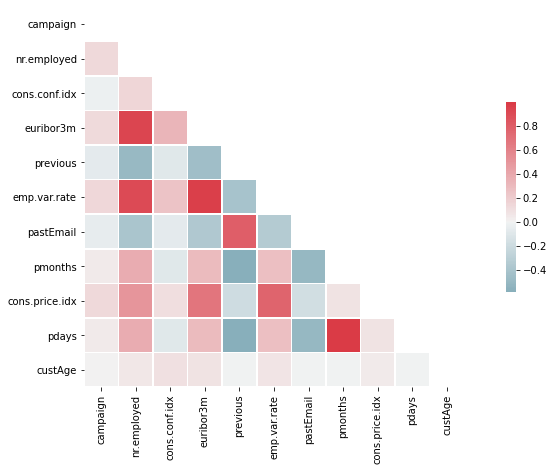

In [7]:
cr = df[numerical_cols].corr()

mk = numpy.zeros_like(cr, dtype=numpy.bool)
mk[numpy.triu_indices_from(mk)] = True
cm = seaborn.diverging_palette(220, 10, as_cmap=True)
cbar_kws={"shrink":.5}

seaborn.heatmap(cr, mask=mk, cmap=cm, center=0, square=True, linewidths=.5, cbar_kws=cbar_kws)

## Missing Values

<div style="text-align:justify">
There are three variables with missing values, they are: <code>custAge, schooling</code> and <code>day_of_week</code>. The <code>schooling</code> and <code>day_of_week</code> variables
they are categorical and we will only indicate a default value when they do not exist. The <code>custAge</code> variable is numeric and we will analyze it in more detail to decide how to fill in the missing values.
</div>

In [8]:
df.isnull().sum()

custAge           1804
profession           0
marital              0
schooling         2127
default              0
housing              0
loan                 0
contact              0
month                0
day_of_week        705
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
pmonths              0
pastEmail            0
responded            0
not_prev_cont        0
is_empty_day         0
dtype: int64

## Customer Age

Detailed analysis of the Customer Age variable

### Sample Skewness

<div style="text-align:justify">
We can see that the variable has a high rate of asymmetry, this means that we will have to normalize it. This normalization is made later, in Block 15.
</div>

Skewness Rate: 0.4477330239487144


[]

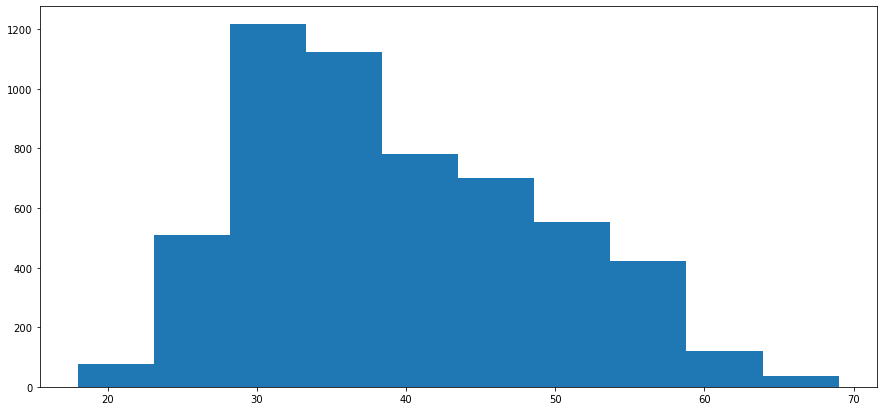

In [9]:
cust_age_values = df[~df['custAge'].isna()]['custAge'].values
print('Skewness Rate: {}'.format(skew(cust_age_values)))
pyplot.hist(cust_age_values)
pyplot.plot()

### Boxplot - Target Correlation

<div style="text-align:justify">
We can also observe that there is no strong correlation between the <code>custAge</code> variable and the target variable. We can also notice that for the medians of both classes (<code>no</code> / <code>yes</code>) they are very similar, indicating that this can be a good value to fill in the missing data.
</div>
<br>
In both classes there are outliers to be removed. <code>custAge> = 70</code>.

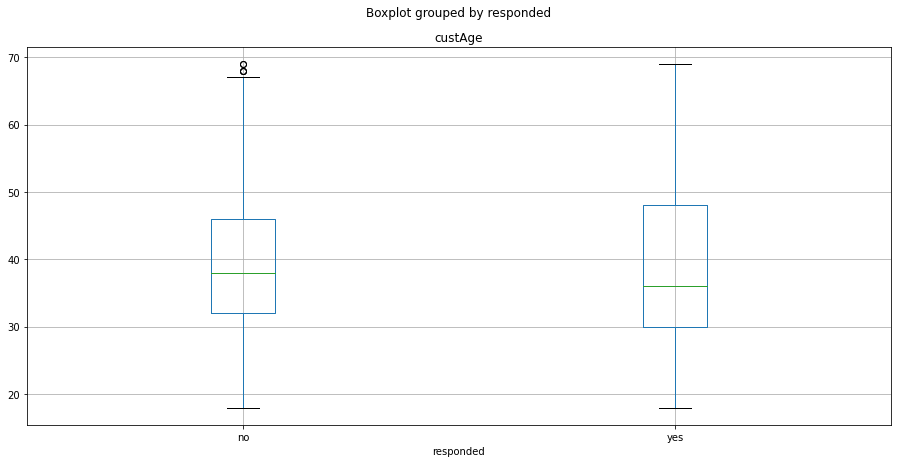

In [10]:
df[['custAge','responded']].boxplot(['custAge'], 'responded')
pyplot.show()

## Schooling

<div style="text-align:justify">
This is a categorical variable. In this case, we will create a value that indicates that the column is empty. We will do that later, in Block 13.
</div>

In [11]:
df['schooling'].value_counts()

university.degree      1549
high.school            1210
basic.9y                781
professional.course     662
basic.4y                507
basic.6y                275
unknown                 222
illiterate                1
Name: schooling, dtype: int64

## Day of Week

<div style="text-align:justify">
This is a categorical variable. In this case, we will create a value that indicates that the column is empty. We will do this later, in the next block (Block 13).
</div>

In [12]:
df['day_of_week'].value_counts()

mon    1424
thu    1362
tue    1317
wed    1286
fri    1240
Name: day_of_week, dtype: int64

## Resolve Missing Values

<div style="text-align:justify">
For the <code>schooling</code> and <code>day_of_week</code> categorical variables we will create a value indicating when the column is empty (<i>empty</i>). For the <code>custAge</code> variable, we will use the median to solve the missing values. Block 10 shows more details about choosing the median.</div>

In [13]:
def resolve_missing_values(df):
    df_missing = df.copy()

    age_avg = df_missing['custAge'].median()
    df_missing['custAge'] = df_missing['custAge'].fillna(age_avg)

    df_missing['schooling'] = df_missing['schooling'].fillna('empty')
    df_missing['day_of_week'] = df_missing['day_of_week'].fillna('empty')
    
    return df_missing

df_missing = resolve_missing_values(df)
df_missing.isnull().sum()

custAge           0
profession        0
marital           0
schooling         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
pmonths           0
pastEmail         0
responded         0
not_prev_cont     0
is_empty_day      0
dtype: int64

## Isolate Binary Columns

In [14]:
bin_values = df_missing[binary_cols].values
df_binary = pandas.DataFrame(data=bin_values, columns=['not_prev_cont', 'is_empty_day'])

## Isolate Numerical Columns

<div style="text-align:justify">
As noted in Block 9, the continuous variables may not be normalized and this may hinder the convergence of machine learning algorithms. Next, we will normalize the values with mean = 0 and standard deviation = 1. We will use the <code>StandardScaler</code> class for this normalization. Other normalizations could be used here, like <code>MinMaxScaler</code> and <code>Yeo-johnson</code>. I opted for the normalization of mean = 0 to guarantee the distribution center at a controlled value.
</div>

In [15]:
num_values = df_missing[numerical_cols].values

scaler = StandardScaler().fit(num_values)
df_scaled_num = pandas.DataFrame(data=scaler.transform(num_values))

df_scaled_num.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.564086,0.404011,-0.302511,0.334155,-0.351202,-0.114728,-0.283913,0.196255,-0.652901,0.196254,1.897969
1,-0.564086,0.853563,-0.454918,0.778416,-0.351202,0.850490,-0.283913,0.196255,0.597399,0.196254,-0.132257
2,-0.564086,0.337204,0.916746,0.718911,-0.351202,0.657446,-0.283913,0.196255,0.729742,0.196254,0.345444
3,-0.193718,0.853563,-0.454918,0.779571,-0.351202,0.850490,-0.283913,0.196255,0.597399,0.196254,1.897969
4,0.917385,-0.941863,-1.216953,-1.341211,1.634698,-1.208641,0.530727,0.196255,-1.187501,0.196254,-0.132257


## Isolate Categorical Columns

<div style="text-align:justify">
Some algorithms are able to work directly with categorical variables, most cases of the decision tree models for example. However, most models need to be transformed into value. For this reason, we will transform categorical variables into the One-Hot Encoding format.
</div>

In [16]:
encoder = OneHotEncoder()
encoder.fit(df_missing[categorical_cols])
column_name = encoder.get_feature_names(categorical_cols)

df_features = pandas.DataFrame(
    encoder.transform(df_missing[categorical_cols]).toarray(),
    columns=column_name
)

df_features = df_features.join(df_scaled_num)
df_features = df_features.join(df_binary)

df_features['target'] = df['responded'].values

df_features.head()

,profession_admin.,profession_blue-collar,profession_entrepreneur,profession_housemaid,profession_management,profession_retired,profession_self-employed,profession_services,profession_student,profession_technician,...,4,5,6,7,8,9,10,not_prev_cont,is_empty_day,target
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.351202,-0.114728,-0.283913,0.196255,-0.652901,0.196254,1.897969,1,0,no
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.351202,0.850490,-0.283913,0.196255,0.597399,0.196254,-0.132257,1,0,no
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.351202,0.657446,-0.283913,0.196255,0.729742,0.196254,0.345444,1,0,no
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.351202,0.850490,-0.283913,0.196255,0.597399,0.196254,1.897969,1,0,no
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.634698,-1.208641,0.530727,0.196255,-1.187501,0.196254,-0.132257,1,0,no


## Train / Test Split

<div style="text-align:justify">
Here we will separate the training and test data from the model. We will use 70% of the data for training and reserve 30% for testing.
</div>

### Train Dataset

In [17]:
df_data_tra = df_features.sample(frac=0.70, random_state=42)
df_data_tra['target'].value_counts()

no     4569
yes     565
Name: target, dtype: int64

### Test Dataset

In [18]:
df_data_tes = df_features.drop(df_data_tra.index)
df_data_tes['target'].value_counts()

no     1959
yes     241
Name: target, dtype: int64

### Balancing Labels

<div style="text-align:justify">
The data is unbalanced (there are many more records for a specific class), so let's use the <code>RandomOverSampler</code> class to do this balancing. An alternative would be to use the <code>SMOTE</code> class, but I chose the <code>RandomOverSampler</code> class because it uses a normal distribution with mean = 0. This was the criterion used for data normalization (Block 15) .
</div>

In [19]:
X_tra = df_data_tra.drop(['target'], axis=1).values
y_tra = df_data_tra[['target']].values

X_tes = df_data_tes.drop(['target'], axis=1).values
y_tes = df_data_tes[['target']].values

oversample = RandomOverSampler(random_state=42)
X_over, y_over = oversample.fit_resample(X_tra, y_tra)

## Auxiliar Plot Functions

### Plot ROC Curve

In [20]:
def plot_roc_curve(classifier, X_tes, y_tes):
    metrics.plot_roc_curve(classifier, X_tes, y_tes)
    pyplot.show()

### Plot Precision Recall Curve

In [21]:
def plot_precision_recall_curve(classifier, X_tes):
    y_scores = classifier.predict_proba(X_tes)[:, 1]
    yn_tes = numpy.where(y_tes == 'yes', 1, 0)

    precisions, recalls, thresholds = metrics.precision_recall_curve(yn_tes, y_scores)

    pyplot.title('Precision and Recall Scores as a function of the decision threshold')
    pyplot.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    pyplot.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    pyplot.ylabel('Score')
    pyplot.xlabel('Decision Threshold')
    pyplot.legend(loc='best')

### Print Model Statistics

In [22]:
def evaluate(classifier, X_tes, th):
    y_prd = ['yes' if x > th else 'no' for x in classifier.predict_proba(X_tes)[:, 1]]
    print(metrics.classification_report(y_tes, y_prd))
    
    return y_prd

### Plot Confusion Matrix

In [23]:
def plot_confusion_matrix(y_tes, y_prd):
    cm = metrics.confusion_matrix(y_tes, y_prd)
    cmd = metrics.ConfusionMatrixDisplay(cm, display_labels=['no','yes'])

    cmd.plot()

    pyplot.xticks(rotation=0)
    pyplot.show()

## Cross Validation

<div style="text-align:justify">
In K-Fold, you normally divide your data set between 5–10 groups, then you randomly choose one of the groups to be the validation or test group. The rest of the groups come together, to train their model and apply the validation group to compare the result and see what the error rate was. This method is repeated until all groups have passed the validation group and all have an error percentage.
</div>

In [24]:
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

<div style="text-align:justify">
We are going to evaluate two algorithms. We chose an algorithm with gradient-based optimization (<i>Multilayer Perceptron</i>) and an Ensemble. Both algorithms fit nonlinearly separable data.
</div>

## Model 1: Random Forest

<div style="text-align:justify">
We will optimize the model according to the <code>f1_micro</code> metric, which is the <code>f1-score</code>. This is to ensure that we have the best possible balance between precision and recall.
</div>

In [25]:
param_search = { 
    'n_estimators': [500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8, 10],
    'criterion': ['gini', 'entropy']
}

rf_rss = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_search,
    n_iter=5,
    scoring='f1_micro',
    n_jobs=4,
    cv=kfold,
    verbose=3,
    random_state=42
)

rf_rss.fit(X_over, y_over)
rf_classifier = rf_rss.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   24.1s finished


### ROC Curve

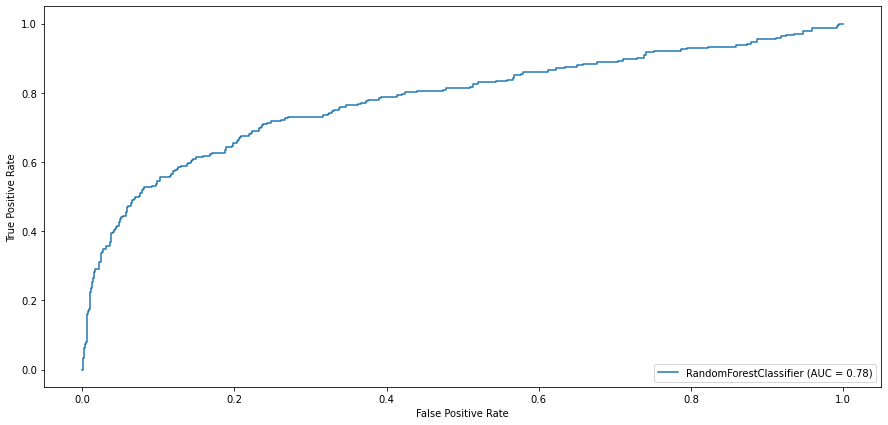

In [26]:
plot_roc_curve(rf_classifier, X_tes, y_tes)

### Precision Recall Curves - Decision Threshold

<div style="text-align:justify">
The point that maximizes precision and recall is <code>0.65</code>.
</div>

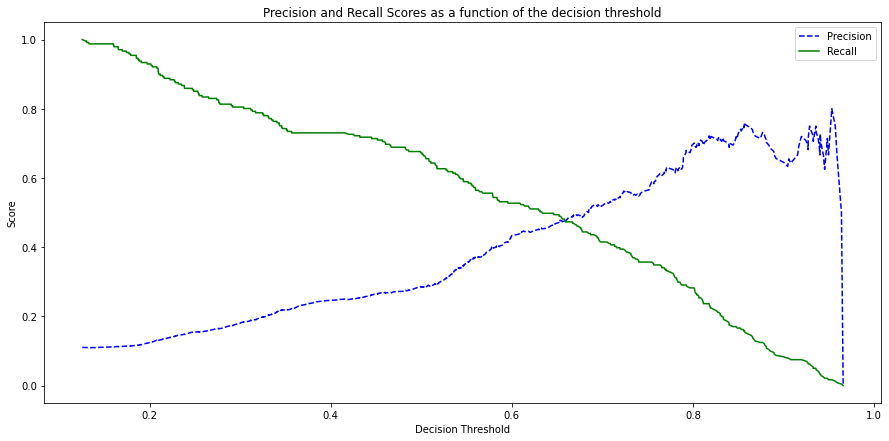

In [27]:
plot_precision_recall_curve(rf_classifier, X_tes)

### Classification Report

In [28]:
rf_y_prd = evaluate(rf_classifier, X_tes, th=0.65)

              precision    recall  f1-score   support

          no       0.94      0.93      0.93      1959
         yes       0.47      0.49      0.48       241

    accuracy                           0.88      2200
   macro avg       0.70      0.71      0.71      2200
weighted avg       0.89      0.88      0.88      2200



### Confusion Matrix

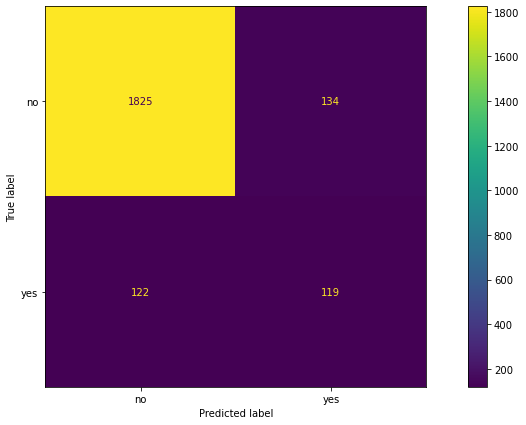

In [29]:
plot_confusion_matrix(y_tes, rf_y_prd)

## Model 2: Multilayer Perceptron

In [30]:
param_search = {
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
    'early_stopping': [True, False],
    'validation_fraction': [0.1, 0.2],
    'epsilon': [1e-10, 1e-8, 1e-7, 1e-5],
    'momentum': [0.6, 0.7, 0.8, 0.9]
}

nn_rss = RandomizedSearchCV(
    MLPClassifier(random_state=42),
    param_distributions=param_search,
    n_iter=5,
    scoring='f1_micro',
    n_jobs=4,
    cv=kfold,
    verbose=3,
    random_state=42
)

nn_rss.fit(X_over, y_over)
nn_classifier = nn_rss.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   44.2s finished


### ROC Curve

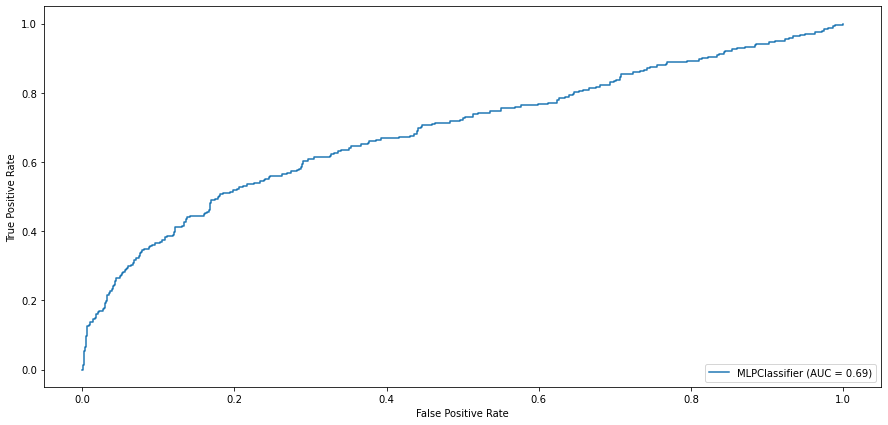

In [31]:
plot_roc_curve(nn_classifier, X_tes, y_tes)

### Precision Recall Curves - Decision Threshold

<div style="text-align:justify">
The point that maximizes precision and recall is <code>0.6</code>.
</div>

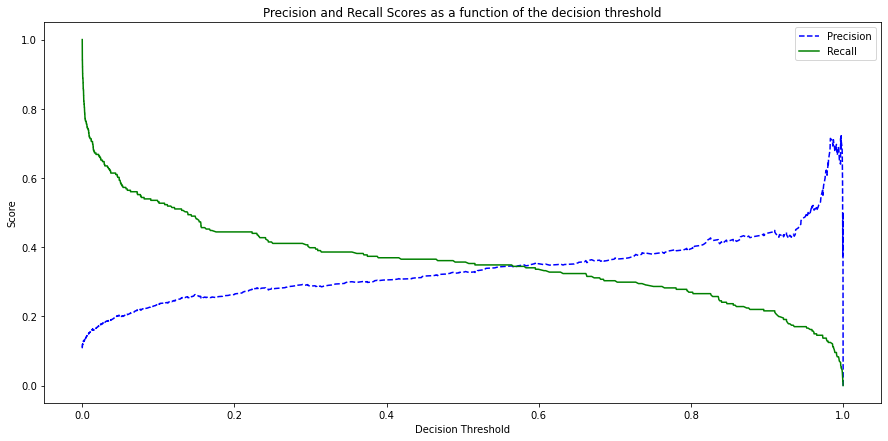

In [32]:
plot_precision_recall_curve(nn_classifier, X_tes)

### Classification Report

In [33]:
nn_y_prd = evaluate(nn_classifier, X_tes, th=0.5)

              precision    recall  f1-score   support

          no       0.92      0.91      0.92      1959
         yes       0.33      0.36      0.34       241

    accuracy                           0.85      2200
   macro avg       0.62      0.63      0.63      2200
weighted avg       0.86      0.85      0.85      2200



### Confusion matrix

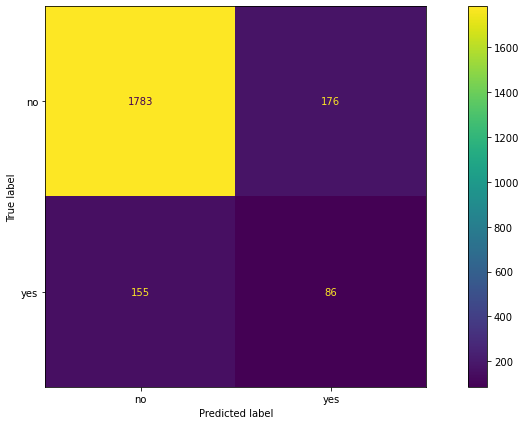

In [34]:
plot_confusion_matrix(y_tes, nn_y_prd)

## Conclusion

<div style="text-align:justify">
We compared the two models and found that <code>Model 1: Random Forest</code> has a better result, comparing the <code>f1-score</code> metric of the minority class. Now we will apply this model to the test data, which will be validated by Spark Cognition.
</div>

### Fetch Test Dataset

In [35]:
df_resp = pandas.read_csv('marketing_test.csv')
df_resp.head(5)

,Unnamed: 0,custAge,profession,marital,schooling,default,housing,loan,contact,month,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail
0,0,NaN,entrepreneur,married,university.degree,no,yes,no,cellular,jul,...,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,999.0,0
1,1,58.0,entrepreneur,married,university.degree,unknown,no,no,telephone,jun,...,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,999.0,0
2,2,48.0,entrepreneur,married,NaN,no,no,no,cellular,jul,...,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999.0,0
3,3,35.0,blue-collar,married,NaN,no,yes,no,telephone,jun,...,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,999.0,0
4,4,39.0,blue-collar,married,basic.6y,no,no,no,cellular,jul,...,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999.0,0


### Resolve Missing Values

In [36]:
df_resp_msv = resolve_missing_values(df_resp)
df_resp_msv = empty_indicator(df_resp_msv)

df_resp_msv.isnull().sum()

Unnamed: 0        0
custAge           0
profession        0
marital           0
schooling         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
pmonths           0
pastEmail         0
not_prev_cont     0
is_empty_day      0
dtype: int64

### Isolate Binary Columns

In [37]:
bin_values_resp = df_resp_msv[binary_cols].values
df_binary_resp = pandas.DataFrame(data=bin_values_resp, columns=['not_prev_cont','is_empty_day'])

### Isolate Numerical Columns

In [38]:
num_values_resp = df_resp_msv[numerical_cols].values

# use trained scaler
df_scaled_num_resp = pandas.DataFrame(data=scaler.transform(num_values_resp))
df_scaled_num_resp.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.193718,0.853563,-0.454918,0.780149,-0.351202,0.85049,-0.283913,0.196255,0.597399,0.196254,-0.132257
1,-0.564086,0.853563,-0.258966,0.777838,-0.351202,0.85049,-0.283913,0.196255,1.549925,0.196254,2.256244
2,-0.564086,0.853563,-0.454918,0.778416,-0.351202,0.85049,-0.283913,0.196255,0.597399,0.196254,1.061994
3,0.547017,0.853563,-0.258966,0.722955,-0.351202,0.85049,-0.283913,0.196255,1.549925,0.196254,-0.490532
4,-0.564086,0.853563,-0.454918,0.778416,-0.351202,0.85049,-0.283913,0.196255,0.597399,0.196254,-0.012832


### Isolate Categorical Columns and Predict

In [39]:
df_features_resp = pandas.DataFrame(
    encoder.transform(df_resp_msv[categorical_cols]).toarray(),
    columns=column_name
)

df_features_resp = df_features_resp.join(df_scaled_num_resp)
df_features_resp = df_features_resp.join(df_binary_resp)

labels = rf_classifier.predict_proba(df_features_resp.values)[:, 1]
df_features_resp['label'] = ['yes' if x > 0.65 else 'no' for x in labels]

df_features_resp['id'] = df_resp['Unnamed: 0'].values

df_labeled = df_features_resp[['id','label']]
df_labeled.head()

,id,label
0,0,no
1,1,no
2,2,no
3,3,no
4,4,no


### Save Labeled Records

In [40]:
df_labeled.to_csv('output.csv', index=False)
df_labeled['label'].value_counts()

no     733
yes     91
Name: label, dtype: int64